In [ ]:
#pip install pandas matplotlib scipy

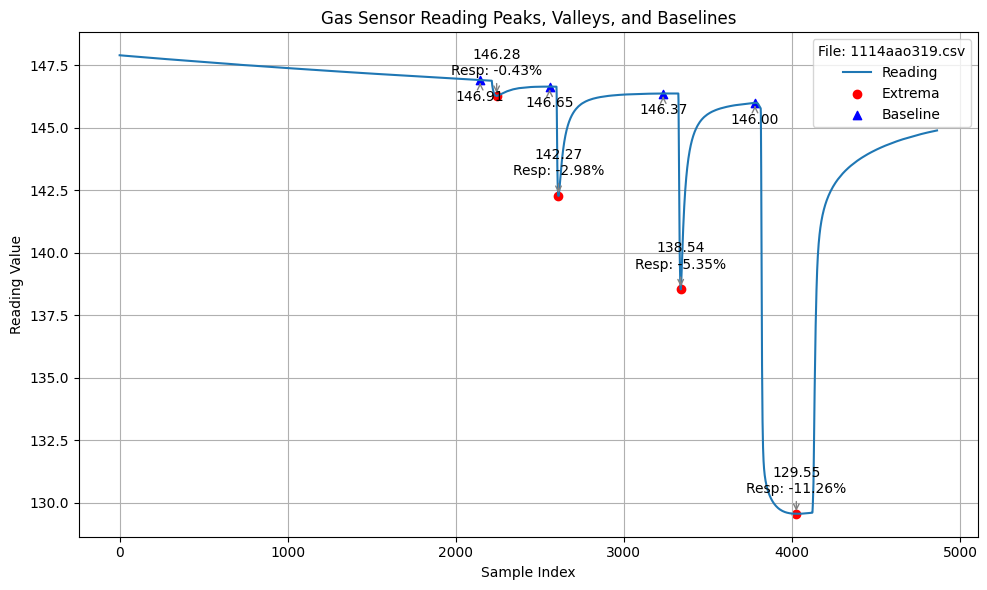

In [2]:
#给探月的原版
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

# 文件名和起始样本点
filename = '1114aao319.csv'
startSamplePoint = 2000  # 默认0，该值为删去前n个采样点
peaksCounts = 4

# 读取 CSV 文件，检查 'Reading' 在第几行
with open(filename, 'r') as file:
    lines = file.readlines()

# 找到 'Reading' 所在行
header_line = 0
for i, line in enumerate(lines):
    if 'Reading' in line:
        header_line = i
        break

# 读取数据并跳过 'Reading' 以上的行
data = pd.read_csv(filename, skiprows=header_line)

# 删除前 startSamplePoint 个数据点
values = data['Reading'].values[startSamplePoint:]

# 计算平均值
mean_value = np.mean(values)

# 寻找局部极值,左右五个数据变化趋势相反
if np.sum(values > mean_value) > len(values) / 2:
    extrema = argrelextrema(values, np.less, order=5)[0]
else:
    extrema = argrelextrema(values, np.greater, order=5)[0]

# 找到每个极值点前导数绝对值发生突变的点作为初始 baseline
initial_baselines = []
for i in extrema:
    if i >= 5:  # 确保至少有5个点可用
        start = max(0, i - 300)
        derivatives = np.diff(values[start:i])
        derivative_changes = np.abs(np.diff(derivatives))
        if len(derivative_changes) > 0:
            initial_baseline_index = start + np.argmax(derivative_changes) + 1
            initial_baselines.append(initial_baseline_index)

# 对初始 baseline 前100个数据点再计算导数，找到突变点替换原来的 baseline
final_baselines = []
for baseline in initial_baselines:
    if baseline >= 100:
        start = baseline - 100
        derivatives = np.diff(values[start:baseline])
        derivative_changes = np.abs(np.diff(derivatives))
        if len(derivative_changes) > 0:
            new_baseline_index = start + np.argmax(derivative_changes) + 1
            # 检查 newbaseline 和 baseline 的差异
            if abs(new_baseline_index - baseline) > 0.0001 * baseline:
                final_baselines.append(new_baseline_index)
            else:
                final_baselines.append(baseline)

# 计算极值和对应baseline差值的绝对值
differences = [abs(values[e] - values[b]) for e, b in zip(extrema, final_baselines)]

# 保留最大的前 pulseCounts 对
pulseCounts = peaksCounts
top_indices = np.argsort(differences)[-pulseCounts:]
filtered_extrema = [extrema[i] for i in top_indices]
filtered_baselines = [final_baselines[i] for i in top_indices]

# 计算 response
responses = [(-values[b] + values[e]) / values[b] * 100 for e, b in zip(filtered_extrema, filtered_baselines)]

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(values, label='Reading')
plt.scatter(filtered_extrema, values[filtered_extrema], color='red', label='Extrema')
plt.scatter(filtered_baselines, values[filtered_baselines], color='blue', label='Baseline', marker='^')

# 在极值点和 baseline 处标出数值和 response，调整标注位置
for i, response in zip(filtered_extrema, responses):
    plt.annotate(f'{values[i]:.2f}\nResp: {response:.2f}%', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, 15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in filtered_baselines:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, -15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='gray'))

plt.xlabel('Sample Index')
plt.ylabel('Reading Value')
plt.title('Gas Sensor Reading Peaks, Valleys, and Baselines')
plt.legend(title=f'File: {filename}')
plt.grid(True)
plt.tight_layout()
plt.show()

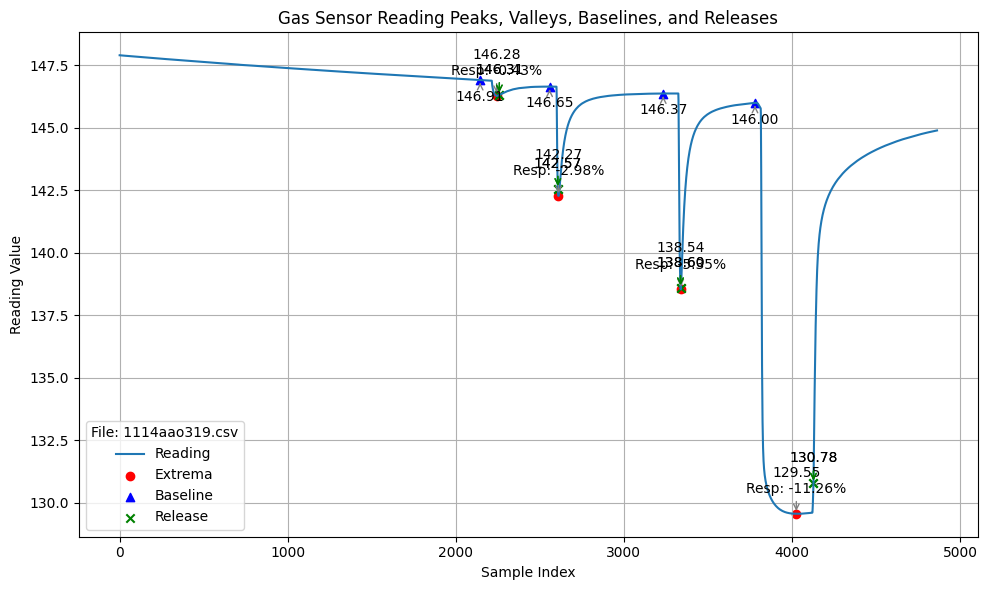

In [6]:
#圆滑曲率算法
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

# 文件名和起始样本点
filename = '1114aao319.csv'
startSamplePoint = 2000  # 默认0，该值为删去前n个采样点
peaksCounts = 4

# 读取 CSV 文件，检查 'Reading' 在第几行
with open(filename, 'r') as file:
    lines = file.readlines()

# 找到 'Reading' 所在行
header_line = 0
for i, line in enumerate(lines):
    if 'Reading' in line:
        header_line = i
        break

# 读取数据并跳过 'Reading' 以上的行
data = pd.read_csv(filename, skiprows=header_line)

# 删除前 startSamplePoint 个数据点
values = data['Reading'].values[startSamplePoint:]

# 计算平均值
mean_value = np.mean(values)

# 寻找局部极值,左右五个数据变化趋势相反
if np.sum(values > mean_value) > len(values) / 2:
    extrema = argrelextrema(values, np.less, order=5)[0]
else:
    extrema = argrelextrema(values, np.greater, order=5)[0]

# 找到每个极值点前导数绝对值发生突变的点作为初始 baseline
initial_baselines = []
for i in extrema:
    if i >= 5:  # 确保至少有5个点可用
        start = max(0, i - 300)
        derivatives = np.diff(values[start:i])
        derivative_changes = np.abs(np.diff(derivatives))
        if len(derivative_changes) > 0:
            initial_baseline_index = start + np.argmax(derivative_changes) + 1
            initial_baselines.append(initial_baseline_index)

# 对初始 baseline 前100个数据点再计算导数，找到突变点替换原来的 baseline
final_baselines = []
for baseline in initial_baselines:
    if baseline >= 100:
        start = baseline - 100
        derivatives = np.diff(values[start:baseline])
        derivative_changes = np.abs(np.diff(derivatives))
        if len(derivative_changes) > 0:
            new_baseline_index = start + np.argmax(derivative_changes) + 1
            if abs(new_baseline_index - baseline) > 0.0001 * baseline:
                final_baselines.append(new_baseline_index)
            else:
                final_baselines.append(baseline)

# 计算极值和对应baseline差值的绝对值
differences = [abs(values[e] - values[b]) for e, b in zip(extrema, final_baselines)]

# 保留最大的前 pulseCounts 对
pulseCounts = peaksCounts
top_indices = np.argsort(differences)[-pulseCounts:]
filtered_extrema = [extrema[i] for i in top_indices]
filtered_baselines = [final_baselines[i] for i in top_indices]

# 计算 response
responses = [(-values[b] + values[e]) / values[b] * 100 for e, b in zip(filtered_extrema, filtered_baselines)]

# 检测 release 点
   # 使用中心差分法计算一阶和二阶导数
        #改进曲率计算的方法：
# 使用二阶导数：
# 曲率可以通过计算二阶导数来近似。对于每个点，可以使用中心差分法计算二阶导数。
# 引入更多点：
# 考虑更多的相邻点，以平滑曲线并减少噪声对曲率计算的影响。
# 标准化处理：
# 在计算曲率之前对数据进行标准化处理，以减少量纲对计算的影响。
release_points = []
for e in filtered_extrema:
    start = max(0, e - 5)
    end = min(len(values), e + 300)
    max_curvature = 0
    release_index = e

    for p in range(start + 1, end - 1):
     
        if (p > 0 and p < len(values) - 1):
            dy1 = (values[p] - values[p - 1])
            dy2 = (values[p + 1] - values[p])
            ddy = dy2 - dy1

            curvature = abs(ddy)

            if curvature > max_curvature:
                max_curvature = curvature
                release_index = p

    release_points.append(release_index)

    release_points.append(release_index)

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(values, label='Reading')
plt.scatter(filtered_extrema, values[filtered_extrema], color='red', label='Extrema')
plt.scatter(filtered_baselines, values[filtered_baselines], color='blue', label='Baseline', marker='^')
plt.scatter(release_points, values[release_points], color='green', label='Release', marker='x')

# 在极值点和 baseline 处标出数值和 response，调整标注位置
for i, response in zip(filtered_extrema, responses):
    plt.annotate(f'{values[i]:.2f}\nResp: {response:.2f}%', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, 15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in filtered_baselines:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, -15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in release_points:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, 15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='green'))

plt.xlabel('Sample Index')
plt.ylabel('Reading Value')
plt.title('Gas Sensor Reading Peaks, Valleys, Baselines, and Releases')
plt.legend(title=f'File: {filename}')
plt.grid(True)
plt.tight_layout()
plt.show()

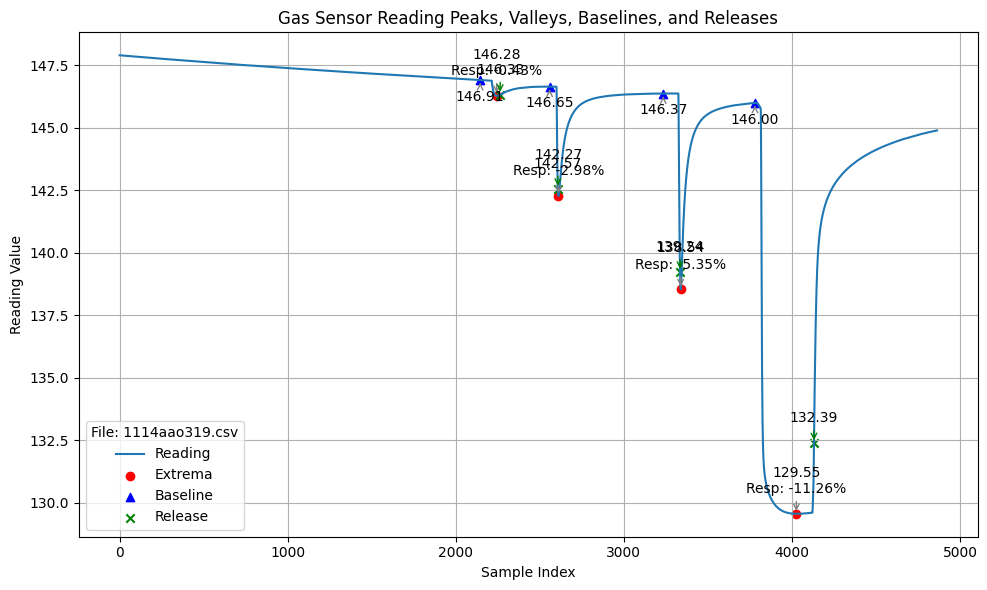

In [30]:
#综合评分算法
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

# 文件名和起始样本点
filename = '1114aao319.csv'
startSamplePoint = 2000  # 默认0，该值为删去前n个采样点
peaksCounts = 4

# 读取 CSV 文件，检查 'Reading' 在第几行
with open(filename, 'r') as file:
    lines = file.readlines()

# 找到 'Reading' 所在行
header_line = 0
for i, line in enumerate(lines):
    if 'Reading' in line:
        header_line = i
        break

# 读取数据并跳过 'Reading' 以上的行
data = pd.read_csv(filename, skiprows=header_line)

# 删除前 startSamplePoint 个数据点
values = data['Reading'].values[startSamplePoint:]

# 计算平均值
mean_value = np.mean(values)

# 寻找局部极值,左右五个数据变化趋势相反
if np.sum(values > mean_value) > len(values) / 2:
    extrema = argrelextrema(values, np.less, order=5)[0]
else:
    extrema = argrelextrema(values, np.greater, order=5)[0]

# 找到每个极值点前导数绝对值发生突变的点作为初始 baseline
initial_baselines = []
for i in extrema:
    if i >= 5:
        start = max(0, i - 300)
        derivatives = np.diff(values[start:i])
        derivative_changes = np.abs(np.diff(derivatives))
        if len(derivative_changes) > 0:
            initial_baseline_index = start + np.argmax(derivative_changes) + 1
            initial_baselines.append(initial_baseline_index)

# 对初始 baseline 前100个数据点再计算导数，找到突变点替换原来的 baseline
final_baselines = []
for baseline in initial_baselines:
    if baseline >= 100:
        start = baseline - 100
        derivatives = np.diff(values[start:baseline])
        derivative_changes = np.abs(np.diff(derivatives))
        if len(derivative_changes) > 0:
            new_baseline_index = start + np.argmax(derivative_changes) + 1
            if abs(new_baseline_index - baseline) > 0.0001 * baseline:
                final_baselines.append(new_baseline_index)
            else:
                final_baselines.append(baseline)

# 计算极值和对应baseline差值的绝对值
differences = [abs(values[e] - values[b]) for e, b in zip(extrema, final_baselines)]

# 保留最大的前 pulseCounts 对
pulseCounts = peaksCounts
top_indices = np.argsort(differences)[-pulseCounts:]
filtered_extrema = [extrema[i] for i in top_indices]
filtered_baselines = [final_baselines[i] for i in top_indices]

# 计算 response
responses = [(-values[b] + values[e]) / values[b] * 100 for e, b in zip(filtered_extrema, filtered_baselines)]

# 检测 release 点，使用斜率评分
release_points = []
for e in filtered_extrema:
    start = max(0, e - 5)
    end = min(len(values), e + 300)
    
    # 初始化评分
    slope_scores = np.zeros(end - start)
    distance_scores = np.zeros(end - start)
    
    # 计算斜率评分
    max_slope = 0
    for p in range(start + 1, end):
        slope = abs(values[p] - values[p - 1])
        slope_scores[p - start] = slope
        max_slope = max(max_slope, slope)
    
    if max_slope > 0:
        slope_scores = (slope_scores / max_slope) * 100
    
    # 计算距离评分
    max_distance = end - start
    for p in range(start, end):
        distance = abs(p - e)
        distance_scores[p - start] = (1 - distance / max_distance) * 280
    
    # 总评分
    total_scores = slope_scores + distance_scores
    release_index = start + np.argmax(total_scores)
    release_points.append(release_index)

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(values, label='Reading')
plt.scatter(filtered_extrema, values[filtered_extrema], color='red', label='Extrema')
plt.scatter(filtered_baselines, values[filtered_baselines], color='blue', label='Baseline', marker='^')
plt.scatter(release_points, values[release_points], color='green', label='Release', marker='x')

# 在极值点和 baseline 处标出数值和 response，调整标注位置
for i, response in zip(filtered_extrema, responses):
    plt.annotate(f'{values[i]:.2f}\nResp: {response:.2f}%', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, 15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in filtered_baselines:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, -15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in release_points:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, 15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='green'))

plt.xlabel('Sample Index')
plt.ylabel('Reading Value')
plt.title('Gas Sensor Reading Peaks, Valleys, Baselines, and Releases')
plt.legend(title=f'File: {filename}')
plt.grid(True)
plt.tight_layout()
plt.show()

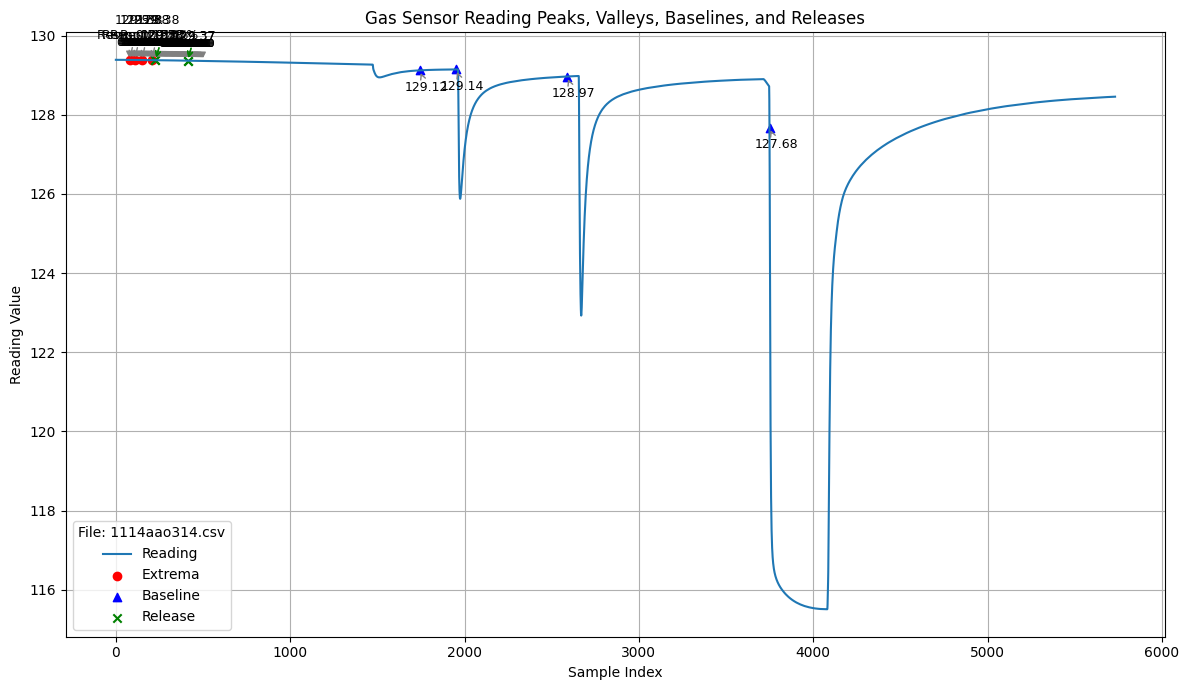

In [36]:
#显示图片曲率
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

# 文件名和起始样本点
filename = '1114aao314.csv'
startSamplePoint = 2000
peaksCounts = 4

# 读取 CSV 文件
with open(filename, 'r') as file:
    lines = file.readlines()

# 找到 'Reading' 所在行
header_line = 0
for i, line in enumerate(lines):
    if 'Reading' in line:
        header_line = i
        break

# 读取数据并跳过 'Reading' 以上的行
data = pd.read_csv(filename, skiprows=header_line)
values = data['Reading'].values[startSamplePoint:]

# 计算平均值
mean_value = np.mean(values)

# 寻找局部极值
if np.sum(values > mean_value) > len(values) / 2:
    extrema = argrelextrema(values, np.less, order=5)[0]
else:
    extrema = argrelextrema(values, np.greater, order=5)[0]

# 找到每个极值点前导数绝对值发生突变的点作为初始 baseline
initial_baselines = []
for i in extrema:
    if i >= 5:
        start = max(0, i - 300)
        derivatives = np.diff(values[start:i])
        derivative_changes = np.abs(np.diff(derivatives))
        if len(derivative_changes) > 0:
            initial_baseline_index = start + np.argmax(derivative_changes) + 1
            initial_baselines.append(initial_baseline_index)

# 对初始 baseline 前100个数据点再计算导数
final_baselines = []
for baseline in initial_baselines:
    if baseline >= 100:
        start = baseline - 100
        derivatives = np.diff(values[start:baseline])
        derivative_changes = np.abs(np.diff(derivatives))
        if len(derivative_changes) > 0:
            new_baseline_index = start + np.argmax(derivative_changes) + 1
            if abs(new_baseline_index - baseline) > 0.0001 * baseline:
                final_baselines.append(new_baseline_index)
            else:
                final_baselines.append(baseline)

# 计算极值和对应baseline差值的绝对值
differences = [abs(values[e] - values[b]) for e, b in zip(extrema, final_baselines)]

# 保留最大的前 pulseCounts 对
pulseCounts = peaksCounts
top_indices = np.argsort(differences)[-pulseCounts:]
filtered_extrema = [extrema[i] for i in top_indices]
filtered_baselines = [final_baselines[i] for i in top_indices]

# 计算 response
responses = [(-values[b] + values[e]) / values[b] * 100 for e, b in zip(filtered_extrema, filtered_baselines)]

# 检测 release 点并记录曲率
release_points = []
curvatures = {}
for e in filtered_extrema:
    start = max(0, e - 5)
    end = min(len(values), e + 300)
    max_curvature = 0
    release_index = e

    for p in range(start + 1, end - 1):
        if (p > 0 and p < len(values) - 1):
            dy1 = (values[p] - values[p - 1])
            dy2 = (values[p + 1] - values[p])
            ddy = dy2 - dy1

            curvature = abs(ddy)
            curvatures[p] = curvature

            if curvature > max_curvature:
                max_curvature = curvature
                release_index = p

    release_points.append(release_index)

# 绘制图表
plt.figure(figsize=(12, 7))
plt.plot(values, label='Reading')
plt.scatter(filtered_extrema, values[filtered_extrema], color='red', label='Extrema')
plt.scatter(filtered_baselines, values[filtered_baselines], color='blue', label='Baseline', marker='^')
plt.scatter(release_points, values[release_points], color='green', label='Release', marker='x')

# 标注曲率，每隔5个点标注一次
for i, curvature in curvatures.items():
    if (i - startSamplePoint) % 5 == 0:
        plt.annotate(f'{curvature:.2f}', 
                     (i, values[i]), 
                     textcoords="offset points", 
                     xytext=(0, 10), 
                     ha='center',
                     fontsize=8,
                     arrowprops=dict(arrowstyle='->', color='gray'))

# 在极值点和 baseline 处标出数值和 response
for i, response in zip(filtered_extrema, responses):
    plt.annotate(f'{values[i]:.2f}\nResp: {response:.2f}%', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(5, 15), 
                 ha='center',
                 fontsize=9,
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in filtered_baselines:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(5, -15), 
                 ha='center',
                 fontsize=9,
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in release_points:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(5, 15), 
                 ha='center',
                 fontsize=9,
                 arrowprops=dict(arrowstyle='->', color='green'))

plt.xlabel('Sample Index')
plt.ylabel('Reading Value')
plt.title('Gas Sensor Reading Peaks, Valleys, Baselines, and Releases')
plt.legend(title=f'File: {filename}')
plt.grid(True)
plt.tight_layout()
plt.show()

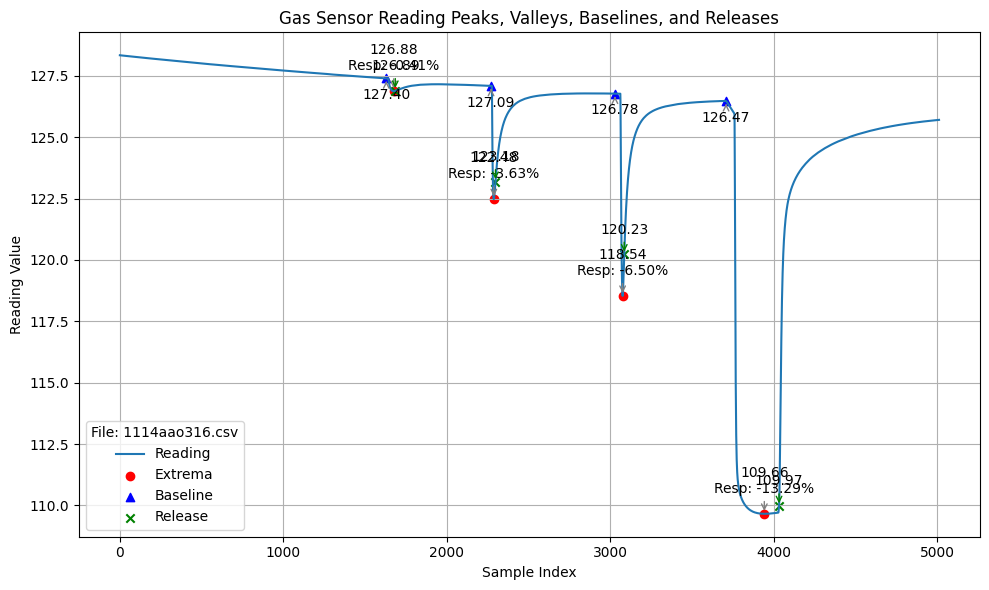

In [42]:
#斜率标准差找release算法
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

# 文件名和起始样本点
filename = '1114aao316.csv'
startSamplePoint = 2000  # 默认0，该值为删去前n个采样点
peaksCounts = 4

# 读取 CSV 文件，检查 'Reading' 在第几行
with open(filename, 'r') as file:
    lines = file.readlines()

# 找到 'Reading' 所在行
header_line = 0
for i, line in enumerate(lines):
    if 'Reading' in line:
        header_line = i
        break

# 读取数据并跳过 'Reading' 以上的行
data = pd.read_csv(filename, skiprows=header_line)

# 删除前 startSamplePoint 个数据点
values = data['Reading'].values[startSamplePoint:]

# 计算平均值
mean_value = np.mean(values)

# 寻找局部极值,左右五个数据变化趋势相反
if np.sum(values > mean_value) > len(values) / 2:
    extrema = argrelextrema(values, np.less, order=5)[0]
else:
    extrema = argrelextrema(values, np.greater, order=5)[0]

# 找到每个极值点前导数绝对值发生突变的点作为初始 baseline
initial_baselines = []
for i in extrema:
    if i >= 5:
        start = max(0, i - 300)
        derivatives = np.diff(values[start:i])
        derivative_changes = np.abs(np.diff(derivatives))
        if len(derivative_changes) > 0:
            initial_baseline_index = start + np.argmax(derivative_changes) + 1
            initial_baselines.append(initial_baseline_index)

# 对初始 baseline 前100个数据点再计算导数，找到突变点替换原来的 baseline
final_baselines = []
for baseline in initial_baselines:
    if baseline >= 100:
        start = baseline - 100
        derivatives = np.diff(values[start:baseline])
        derivative_changes = np.abs(np.diff(derivatives))
        if len(derivative_changes) > 0:
            new_baseline_index = start + np.argmax(derivative_changes) + 1
            if abs(new_baseline_index - baseline) > 0.0001 * baseline:
                final_baselines.append(new_baseline_index)
            else:
                final_baselines.append(baseline)

# 计算极值和对应baseline差值的绝对值
differences = [abs(values[e] - values[b]) for e, b in zip(extrema, final_baselines)]

# 保留最大的前 pulseCounts 对
pulseCounts = peaksCounts
top_indices = np.argsort(differences)[-pulseCounts:]
filtered_extrema = [extrema[i] for i in top_indices]
filtered_baselines = [final_baselines[i] for i in top_indices]

# 计算 response
responses = [(-values[b] + values[e]) / values[b] * 100 for e, b in zip(filtered_extrema, filtered_baselines)]

# 检测 release 点，使用相邻五个数据的窗口
window_size = 30
release_points = []
for e in filtered_extrema:
    start = max(0, e - 5)
    end = min(len(values), e + 300)
    
    # 计算每个窗口的斜率标准差
    max_std = 0
    release_index = start
    for i in range(start, end - window_size + 1):
        window = values[i:i + window_size]
        slopes = np.diff(window)
        std_dev = np.std(slopes)
        
        if std_dev > max_std:
            max_std = std_dev
            release_index = i + window_size // 2  # 中间的数

    release_points.append(release_index)

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(values, label='Reading')
plt.scatter(filtered_extrema, values[filtered_extrema], color='red', label='Extrema')
plt.scatter(filtered_baselines, values[filtered_baselines], color='blue', label='Baseline', marker='^')
plt.scatter(release_points, values[release_points], color='green', label='Release', marker='x')

# 在极值点和 baseline 处标出数值和 response，调整标注位置
for i, response in zip(filtered_extrema, responses):
    plt.annotate(f'{values[i]:.2f}\nResp: {response:.2f}%', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, 15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in filtered_baselines:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, -15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in release_points:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(0, 15), 
                 ha='center',
                 arrowprops=dict(arrowstyle='->', color='green'))

plt.xlabel('Sample Index')
plt.ylabel('Reading Value')
plt.title('Gas Sensor Reading Peaks, Valleys, Baselines, and Releases')
plt.legend(title=f'File: {filename}')
plt.grid(True)
plt.tight_layout()
plt.show()

总数据数: 38799


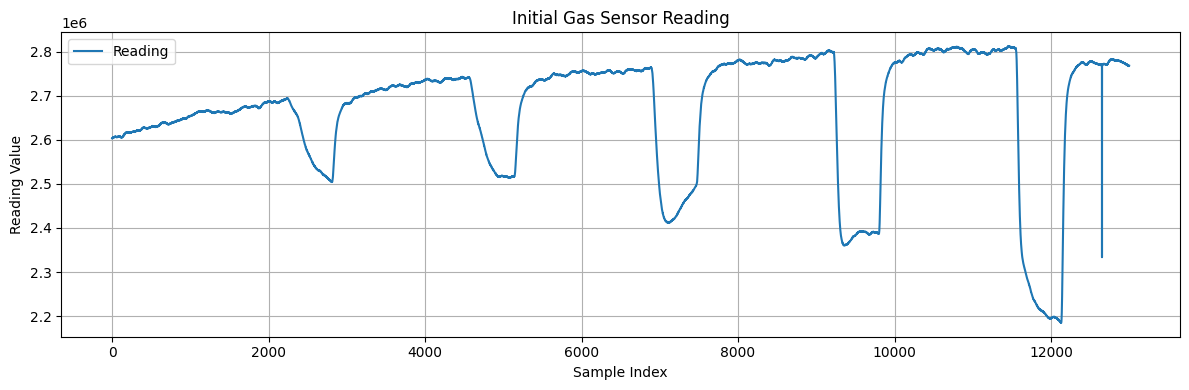

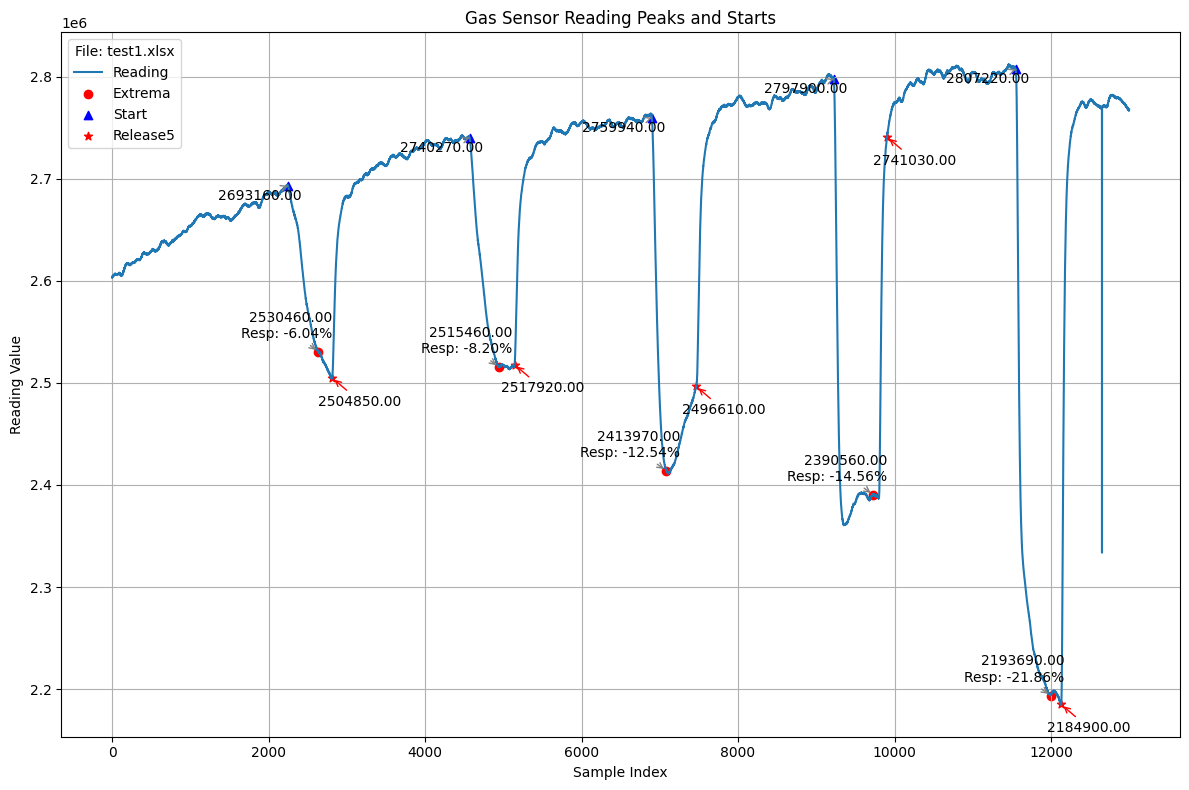

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np
import os

# 文件名和起始、结束样本点
filename = 'test1.xlsx'
startSamplePoint = 0
endSamplePoint = 13000
peaksCounts = 5
peakLength = 500
gasOutTime = 700
gasInTime = 700

# 检查文件类型并读取数据
file_extension = os.path.splitext(filename)[1]

if file_extension == '.csv':
    with open(filename, 'r') as file:
        lines = file.readlines()

    header_line = 0
    for i, line in enumerate(lines):
        if 'Reading' in line:
            header_line = i
            break

    data = pd.read_csv(filename, skiprows=header_line)

elif file_extension == '.xlsx':
    data = pd.read_excel(filename)
    
# 打印Reading列的总数据数
print(f"总数据数: {len(data['Reading'])}")

values = data['Reading'].values[startSamplePoint:endSamplePoint]

plt.figure(figsize=(12, 4))
plt.plot(values, label='Reading')
plt.xlabel('Sample Index')
plt.ylabel('Reading Value')
plt.title('Initial Gas Sensor Reading')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mean_value = np.mean(values)

# 寻找局部极值,左右五个数据变化趋势相反，并记录原始位置
if np.sum(values > mean_value) > len(values) / 2:
    extrema_indices = argrelextrema(values, np.less, order=5)[0]
else:
    extrema_indices = argrelextrema(values, np.greater, order=5)[0]

filtered_extrema_indices = []
last_index = -peakLength

for index in extrema_indices:
    if index - last_index >= peakLength:
        filtered_extrema_indices.append(index)
        last_index = index

# 修改 baseline 寻找算法：在每个 extrema 前1000个数据点范围内使用类似 release5 的算法
starts = []
window_size = 200

for e in filtered_extrema_indices:
    start = max(0, e - gasInTime)
    end = e
    
    max_diff_slope = 0
    start_index = start
    for i in range(start, end - window_size + 1):
        mid_point = i + window_size // 2
        mean_slope_before = np.mean(np.diff(values[i:mid_point]))
        mean_slope_after = np.mean(np.diff(values[mid_point:mid_point + window_size // 2]))
        diff_slope = abs(mean_slope_after - mean_slope_before)
        
        if diff_slope > max_diff_slope:
            max_diff_slope = diff_slope
            start_index = mid_point

    starts.append(start_index)

# 计算极值和对应baseline差值的绝对值
differences = [abs(values[e] - values[s]) for e, s in zip(filtered_extrema_indices, starts)]

# 保留最大的前 peaksCounts 对并筛选条件
if np.sum(values > mean_value) > len(values) / 2:
    valid_pairs = [(diff, e, s) for diff, e, s in zip(differences, filtered_extrema_indices, starts) if values[e] <= values[s]]
else:
    valid_pairs = [(diff, e, s) for diff, e, s in zip(differences, filtered_extrema_indices, starts) if values[e] >= values[s]]

# 按差值排序并选择前 peaksCounts 对
valid_pairs.sort(reverse=True, key=lambda x: x[0])
selected_pairs = valid_pairs[:peaksCounts]

filtered_extrema_indices = [e for _, e, _ in selected_pairs]
filtered_starts = [s for _, _, s in selected_pairs]

# 计算 response
responses = [(-values[s] + values[e]) / values[s] * 100 for e, s in zip(filtered_extrema_indices, filtered_starts)]

# 检测 release5 点
release5 = []

for e in filtered_extrema_indices:
    start = max(0, e - 10)
    end = min(len(values), e + gasOutTime)
    
    max_diff_slope = 0
    release5_index = start
    for i in range(start, end - window_size + 1):
        mid_point = i + window_size // 2
        mean_slope_before = np.mean(np.diff(values[i:mid_point]))
        mean_slope_after = np.mean(np.diff(values[mid_point:mid_point + window_size // 2]))
        diff_slope = abs(mean_slope_after - mean_slope_before)
        
        if diff_slope > max_diff_slope:
            max_diff_slope = diff_slope
            release5_index = mid_point

    release5.append(release5_index)

# 绘制图表
plt.figure(figsize=(12, 8))
plt.plot(values, label='Reading')
plt.scatter(filtered_extrema_indices, values[filtered_extrema_indices], color='red', label='Extrema')
plt.scatter(filtered_starts, values[filtered_starts], color='blue', label='Start', marker='^')

for i, response in zip(filtered_extrema_indices, responses):
    plt.annotate(f'{values[i]:.2f}\nResp: {response:.2f}%', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(10, 10), 
                 ha='right',
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in filtered_starts:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(10, -10), 
                 ha='right',
                 arrowprops=dict(arrowstyle='->', color='gray'))

plt.scatter(release5, values[release5], color='red', label='Release5', marker='*')

for i in release5:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(50, -20), 
                 ha='right',
                 arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel('Sample Index')
plt.ylabel('Reading Value')
plt.title('Gas Sensor Reading Peaks and Starts')
plt.legend(title=f'File: {filename}')
plt.grid(True)
plt.tight_layout()

plt.show()

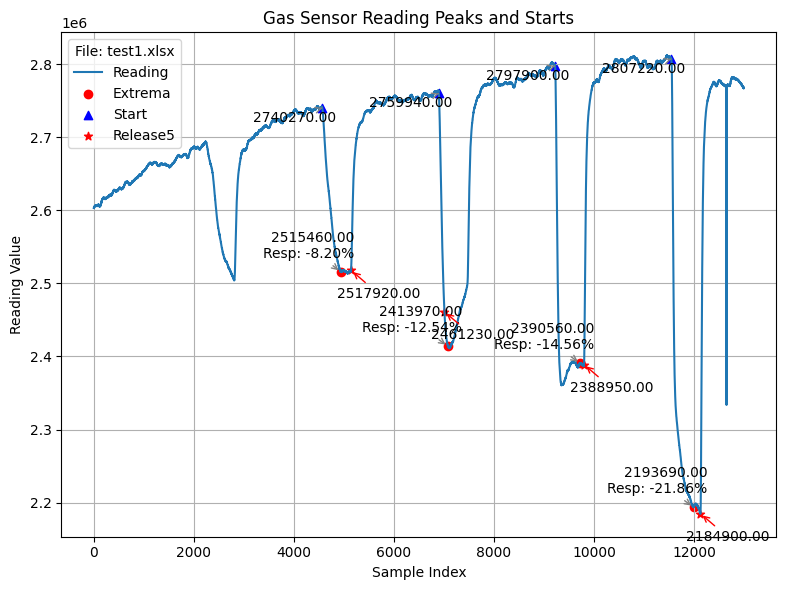

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np
import os
import tkinter as tk
from tkinter import filedialog, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

def generate_plot():
    try:
        filename = file_entry.get()
        startSamplePoint = int(start_entry.get())
        endSamplePoint = int(end_entry.get())
        peaksCounts = int(peaks_entry.get())
        peakLength = int(peak_entry.get())
        gasOutTime = int(gasOut_entry.get())
        gasInTime = int(gasIn_entry.get())
        window_size = int(window_entry.get())

        # 检查文件类型并读取数据
        file_extension = os.path.splitext(filename)[1]

        if file_extension == '.csv':
            with open(filename, 'r') as file:
                lines = file.readlines()

            header_line = 0
            for i, line in enumerate(lines):
                if 'Reading' in line:
                    header_line = i
                    break

            data = pd.read_csv(filename, skiprows=header_line)

        elif file_extension == '.xlsx':
            data = pd.read_excel(filename)

        values = data['Reading'].values[startSamplePoint:endSamplePoint]

        mean_value = np.mean(values)

        # 寻找局部极值
        if np.sum(values > mean_value) > len(values) / 2:
            extrema_indices = argrelextrema(values, np.less, order=5)[0]
        else:
            extrema_indices = argrelextrema(values, np.greater, order=5)[0]

        filtered_extrema_indices = []
        last_index = -peakLength

        for index in extrema_indices:
            if index - last_index >= peakLength:
                filtered_extrema_indices.append(index)
                last_index = index

        # 修改 baseline 寻找算法
        starts = []

        for e in filtered_extrema_indices:
            start = max(0, e - gasInTime)
            end = e
            
            max_diff_slope = 0
            start_index = start
            for i in range(start, end - window_size + 1):
                mid_point = i + window_size // 2
                mean_slope_before = np.mean(np.diff(values[i:mid_point]))
                mean_slope_after = np.mean(np.diff(values[mid_point:mid_point + window_size // 2]))
                diff_slope = abs(mean_slope_after - mean_slope_before)
                
                if diff_slope > max_diff_slope:
                    max_diff_slope = diff_slope
                    start_index = mid_point

            starts.append(start_index)

        # 计算极值和对应baseline差值的绝对值
        differences = [abs(values[e] - values[s]) for e, s in zip(filtered_extrema_indices, starts)]

        # 保留最大的前 peaksCounts 对并筛选条件
        if np.sum(values > mean_value) > len(values) / 2:
            valid_pairs = [(diff, e, s) for diff, e, s in zip(differences, filtered_extrema_indices, starts) if values[e] <= values[s]]
        else:
            valid_pairs = [(diff, e, s) for diff, e, s in zip(differences, filtered_extrema_indices, starts) if values[e] >= values[s]]

        # 按差值排序并选择前 peaksCounts 对
        valid_pairs.sort(reverse=True, key=lambda x: x[0])
        selected_pairs = valid_pairs[:peaksCounts]

        filtered_extrema_indices = [e for _, e, _ in selected_pairs]
        filtered_starts = [s for _, _, s in selected_pairs]

        # 计算 response
        responses = [(-values[s] + values[e]) / values[s] * 100 for e, s in zip(filtered_extrema_indices, filtered_starts)]

        # 检测 release5 点
        release5 = []

        for e in filtered_extrema_indices:
            start = max(0, e - window_size)
            end = min(len(values), e + gasOutTime)
            
            max_diff_slope = 0
            release5_index = start
            for i in range(start, end - window_size + 1):
                mid_point = i + window_size // 2
                mean_slope_before = np.mean(np.diff(values[i:mid_point]))
                mean_slope_after = np.mean(np.diff(values[mid_point:mid_point + window_size // 2]))
                diff_slope = abs(mean_slope_after - mean_slope_before)
                
                if diff_slope > max_diff_slope:
                    max_diff_slope = diff_slope
                    release5_index = mid_point

            release5.append(release5_index)

        # 绘制图表
        fig, ax = plt.subplots(figsize=(8, 6))  # 调整大小
        ax.plot(values, label='Reading')
        ax.scatter(filtered_extrema_indices, values[filtered_extrema_indices], color='red', label='Extrema')
        ax.scatter(filtered_starts, values[filtered_starts], color='blue', label='Start', marker='^')

        for i, response in zip(filtered_extrema_indices, responses):
            ax.annotate(f'{values[i]:.2f}\nResp: {response:.2f}%', 
                        (i, values[i]), 
                        textcoords="offset points", 
                        xytext=(10, 10), 
                        ha='right',
                        arrowprops=dict(arrowstyle='->', color='gray'))
        for i in filtered_starts:
            ax.annotate(f'{values[i]:.2f}', 
                        (i, values[i]), 
                        textcoords="offset points", 
                        xytext=(10, -10), 
                        ha='right',
                        arrowprops=dict(arrowstyle='->', color='gray'))

        ax.scatter(release5, values[release5], color='red', label='Release5', marker='*')

        for i in release5:
            ax.annotate(f'{values[i]:.2f}', 
                        (i, values[i]), 
                        textcoords="offset points", 
                        xytext=(50, -20), 
                        ha='right',
                        arrowprops=dict(arrowstyle='->', color='red'))

        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Reading Value')
        ax.set_title('Gas Sensor Reading Peaks and Starts')
        ax.legend(title=f'File: {filename}')
        ax.grid(True)
        plt.tight_layout()

        # 清除上一个图像
        for widget in plot_frame.winfo_children():
            widget.destroy()

        canvas = FigureCanvasTkAgg(fig, master=plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

    except Exception as e:
        messagebox.showerror("Error", str(e))

def browse_file():
    filename = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx"), ("CSV files", "*.csv")])
    file_entry.delete(0, tk.END)
    file_entry.insert(0, filename)

app = tk.Tk()
app.title("Gas Sensor Data Plotter")

# 左侧输入界面
input_frame = tk.Frame(app)
input_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

tk.Label(input_frame, text="Filename:").grid(row=0, column=0, padx=5, pady=5)
file_entry = tk.Entry(input_frame, width=50)
file_entry.grid(row=0, column=1, padx=5, pady=5)
tk.Button(input_frame, text="Browse", command=browse_file).grid(row=0, column=2, padx=5, pady=5)

# Initialize with your data values
file_entry.insert(0, 'test1.xlsx')
start_entry = tk.Entry(input_frame)
start_entry.insert(0, '0')
end_entry = tk.Entry(input_frame)
end_entry.insert(0, '13000')
peaks_entry = tk.Entry(input_frame)
peaks_entry.insert(0, '4')
peak_entry = tk.Entry(input_frame)
peak_entry.insert(0, '500')
gasOut_entry = tk.Entry(input_frame)
gasOut_entry.insert(0, '700')
gasIn_entry = tk.Entry(input_frame)
gasIn_entry.insert(0, '700')
window_entry = tk.Entry(input_frame)
window_entry.insert(0, '200')

tk.Label(input_frame, text="Start Sample Point:").grid(row=1, column=0, padx=5, pady=5)
start_entry.grid(row=1, column=1, padx=5, pady=5)

tk.Label(input_frame, text="End Sample Point:").grid(row=2, column=0, padx=5, pady=5)
end_entry.grid(row=2, column=1, padx=5, pady=5)

tk.Label(input_frame, text="Peaks Counts:").grid(row=3, column=0, padx=5, pady=5)
peaks_entry.grid(row=3, column=1, padx=5, pady=5)

tk.Label(input_frame, text="Peak Length:").grid(row=4, column=0, padx=5, pady=5)
peak_entry.grid(row=4, column=1, padx=5, pady=5)

tk.Label(input_frame, text="Gas Out Time:").grid(row=5, column=0, padx=5, pady=5)
gasOut_entry.grid(row=5, column=1, padx=5, pady=5)

tk.Label(input_frame, text="Gas In Time:").grid(row=6, column=0, padx=5, pady=5)
gasIn_entry.grid(row=6, column=1, padx=5, pady=5)

tk.Label(input_frame, text="Window Size:").grid(row=7, column=0, padx=5, pady=5)
window_entry.grid(row=7, column=1, padx=5, pady=5)

tk.Button(input_frame, text="Generate", command=generate_plot).grid(row=8, column=0, columnspan=3, pady=10)

# 右侧图像显示区域
plot_frame = tk.Frame(app)
plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

app.mainloop()

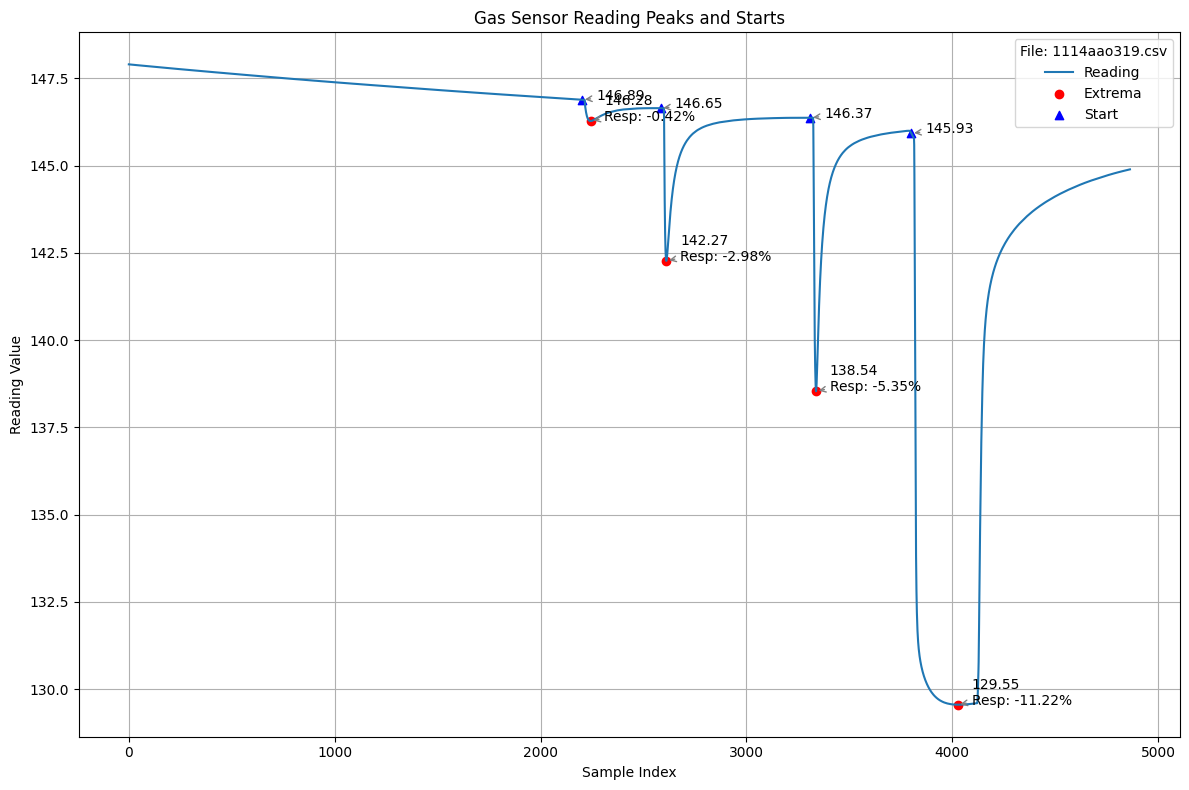

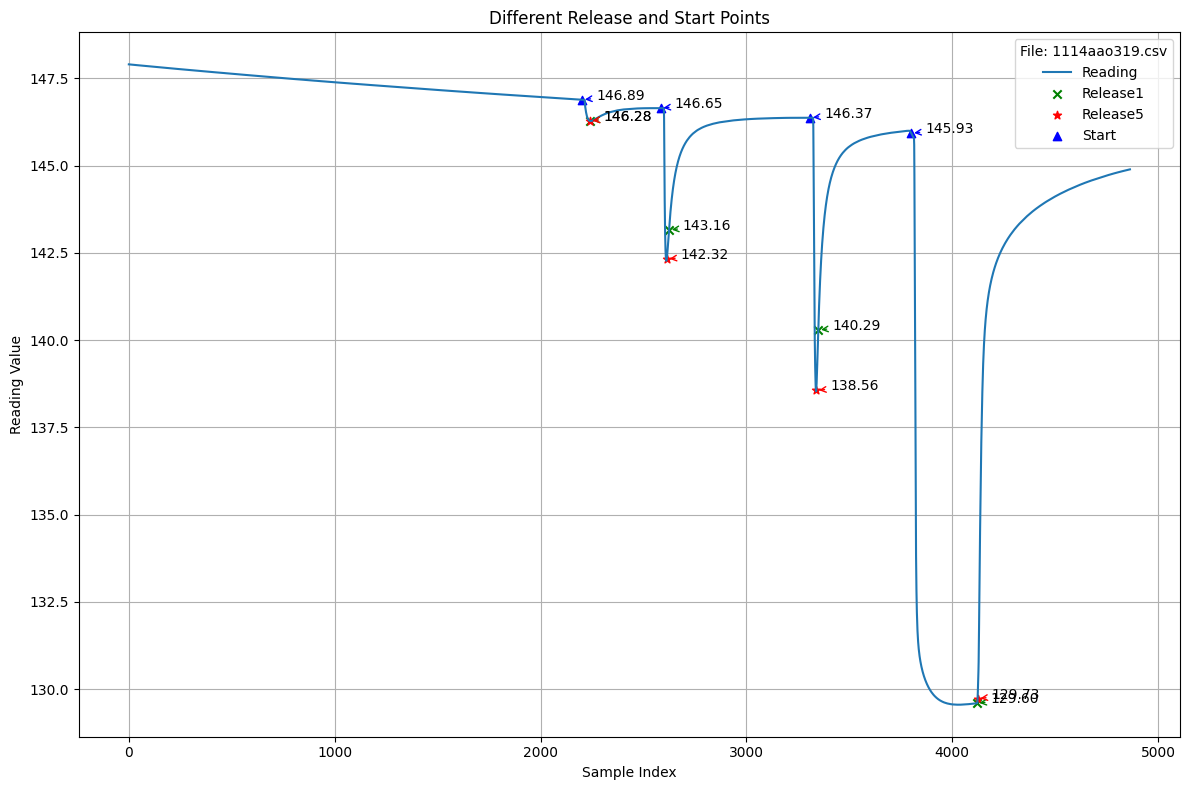

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

# 文件名和起始样本点
filename = '1114aao319.csv'
startSamplePoint = 2000  # 默认0，该值为删去前n个采样点
peaksCounts = 4
window_size = 50

# 读取 CSV 文件，检查 'Reading' 在第几行
with open(filename, 'r') as file:
    lines = file.readlines()

# 找到 'Reading' 所在行
header_line = 0
for i, line in enumerate(lines):
    if 'Reading' in line:
        header_line = i
        break

# 读取数据并跳过 'Reading' 以上的行
data = pd.read_csv(filename, skiprows=header_line)

# 删除前 startSamplePoint 个数据点
values = data['Reading'].values[startSamplePoint:]

# 计算平均值
mean_value = np.mean(values)

# 寻找局部极值,左右五个数据变化趋势相反
if np.sum(values > mean_value) > len(values) / 2:
    extrema = argrelextrema(values, np.less, order=5)[0]
else:
    extrema = argrelextrema(values, np.greater, order=5)[0]

# 修改 baseline 寻找算法：在每个 extrema 前200个数据点范围内使用类似 release1 的算法
starts = []


for e in extrema:
    start = max(0, e - 200)
    end = e
    
    # 最大斜率标准差的中间点作为 baseline
    max_std = 0
    start_index = start
    for i in range(start, end - window_size + 1):
        window = values[i:i + window_size]
        slopes = np.diff(window)
        std_dev = np.std(slopes)
        
        if std_dev > max_std:
            max_std = std_dev
            start_index = i + window_size // 2

    starts.append(start_index)

# 计算极值和对应baseline差值的绝对值
differences = [abs(values[e] - values[s]) for e, s in zip(extrema, starts)]

# 保留最大的前 pulseCounts 对
pulseCounts = peaksCounts
top_indices = np.argsort(differences)[-pulseCounts:]
filtered_extrema = [extrema[i] for i in top_indices]
filtered_starts = [starts[i] for i in top_indices]

# 计算 response
responses = [(-values[s] + values[e]) / values[s] * 100 for e, s in zip(filtered_extrema, filtered_starts)]

# 检测 release 点
release1 = []
release5 = []

for e in filtered_extrema:
    start = max(0, e - 50)
    end = min(len(values), e + 300)
    
    # release1: 最大斜率标准差的中间点
    max_std = 0
    release1_index = start
    for i in range(start, end - window_size + 1):
        window = values[i:i + window_size]
        slopes = np.diff(window)
        std_dev = np.std(slopes)
        
        if std_dev > max_std:
            max_std = std_dev
            release1_index = i + window_size // 2

    release1.append(release1_index)

    # release5: 窗口内平均斜率差值最大的点
    max_diff_slope = 0
    release5_index = start
    
    for i in range(start, end - window_size + 1):
        mid_point = i + window_size // 2
        mean_slope_before = np.mean(np.diff(values[i:mid_point]))
        mean_slope_after = np.mean(np.diff(values[mid_point:mid_point + window_size // 2]))
        diff_slope = abs(mean_slope_after - mean_slope_before)
        
        if diff_slope > max_diff_slope:
            max_diff_slope = diff_slope
            release5_index = mid_point

    release5.append(release5_index)

# 绘制第一个图表
plt.figure(figsize=(12, 8))
plt.plot(values, label='Reading')
plt.scatter(filtered_extrema, values[filtered_extrema], color='red', label='Extrema')
plt.scatter(filtered_starts, values[filtered_starts], color='blue', label='Start', marker='^')

# 在极值点和 baseline 处标出数值和 response，调整标注位置
for i, response in zip(filtered_extrema, responses):
    plt.annotate(f'{values[i]:.2f}\nResp: {response:.2f}%', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(10, 0), 
                 ha='left',
                 arrowprops=dict(arrowstyle='->', color='gray'))
for i in filtered_starts:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(10, 0), 
                 ha='left',
                 arrowprops=dict(arrowstyle='->', color='gray'))

plt.xlabel('Sample Index')
plt.ylabel('Reading Value')
plt.title('Gas Sensor Reading Peaks and Starts')
plt.legend(title=f'File: {filename}')
plt.grid(True)
plt.tight_layout()

# 绘制第二个图表
plt.figure(figsize=(12, 8))
plt.plot(values, label='Reading')
plt.scatter(release1, values[release1], color='green', label='Release1', marker='x')
plt.scatter(release5, values[release5], color='red', label='Release5', marker='*')
plt.scatter(filtered_starts, values[filtered_starts], color='blue', label='Start', marker='^')

# 标注 release 和 start 点
for i in release1:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(10, 0), 
                 ha='left',
                 arrowprops=dict(arrowstyle='->', color='green'))
for i in release5:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(10, 0), 
                 ha='left',
                 arrowprops=dict(arrowstyle='->', color='red'))
for i in filtered_starts:
    plt.annotate(f'{values[i]:.2f}', 
                 (i, values[i]), 
                 textcoords="offset points", 
                 xytext=(10, 0), 
                 ha='left',
                 arrowprops=dict(arrowstyle='->', color='blue'))

plt.xlabel('Sample Index')
plt.ylabel('Reading Value')
plt.title('Different Release and Start Points')
plt.legend(title=f'File: {filename}')
plt.grid(True)
plt.tight_layout()

plt.show()